In [3]:
import os  
import sys  
import glob  
  
import numpy as np  
import pandas as pd  
  
import matplotlib.pylab as plt  
from matplotlib_venn import venn2  
import seaborn as sns  
  
from tqdm import tqdm  
from itertools import cycle  
  
from sklearn import metrics  
from sklearn import model_selection  
from sklearn import preprocessing  
from sklearn import linear_model  
from sklearn import feature_selection  
  
import lightgbm as lgb  
import xgboost as xgb  
import catboost as cat  
  
import optbinning  
  
pd.set_option("display.max_columns", None)  
  
plt.style.use("ggplot")  
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]  
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])  

In [4]:
%%time  
train_dataframe = pd.read_feather('train.feather')  
test_dataframe = pd.read_feather('test.feather')  
train_labels = pd.read_csv("train_labels.csv")  
train_dataframe.shape, test_dataframe.shape  

CPU times: total: 1min 34s
Wall time: 53.5 s


((5531451, 190), (11363762, 190))

In [5]:
train_dataframe.head()  

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,NaN,NaN,0.000630,0.080994,0.708984,0.170654,0.006203,0.358643,0.525391,0.255615,NaN,0.063904,0.059418,0.006466,0.148682,1.335938,0.008209,0.001423,0.207275,0.736328,0.096191,NaN,0.023376,0.002768,0.008324,1.001953,0.008301,0.161377,0.148315,0.922852,0.354492,0.151978,0.118103,0.001882,0.158569,0.065735,0.018387,0.063660,0.199585,0.308350,0.016357,0.401611,0.091064,0,1,0.007126,0.007664,NaN,0.652832,0.008522,-1,0.004730,6,0.271973,0.008362,0.515137,0.002644,0.009010,0.004807,0.008339,0.119385,0.004803,0.108276,0.050873,NaN,0.007553,0.080444,0.069092,NaN,0.004326,0.007561,NaN,0.007729,0.000272,0.001575,0.004238,0.001434,NaN,0.002272,0.004059,0.007122,0.002457,0.002310,0.003532,0.506836,0.008034,1.009766,0.084656,0.003820,0.007042,0.000438,0.006451,0.000830,0.005054,NaN,0,0.005722,0.007084,NaN,0.000198,0.008911,NaN,1.0,0.002537,0.005177,0.006626,0.009705,0.007782,0.002449,1.000977,0.002665,0.007481,0.006893,1.503906,1.005859,0.003569,0.008873,0.003948,0.003647,0.004951,0.894043,0.135620,0.911133,0.974609,0.001244,0.766602,1.008789,1.004883,0.893555,NaN,0.669922,0.009972,0.004570,NaN,1.008789,2,NaN,0.004326,NaN,NaN,NaN,1.007812,0.210083,0.676758,0.007874,1,0.238281,0,4,0.232178,0.236206,0,0.702148,0.434326,0.003057,0.686523,0.008743,1,1.002930,1.007812,1.000000,0.006805,NaN,0.002052,0.005970,NaN,0.004345,0.001534,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,NaN,NaN,0.002525,0.069397,0.712891,0.113220,0.006207,0.353516,0.521484,0.223389,NaN,0.065247,0.057739,0.001614,0.149780,1.339844,0.008369,0.001984,0.202759,0.720703,0.099792,NaN,0.030594,0.002748,0.002481,1.008789,0.005135,0.140991,0.143555,0.919434,0.326660,0.156250,0.118713,0.001610,0.148438,0.093933,0.013039,0.065491,0.151367,0.265137,0.017685,0.406250,0.086792,0,1,0.002413,0.007149,NaN,0.646973,0.002237,-1,0.003880,6,0.188965,0.004028,0.509277,0.004192,0.007843,0.001283,0.006523,0.140625,0.000094,0.101013,0.040466,NaN,0.004833,0.081421,0.074158,NaN,0.004204,0.005302,NaN,0.001864,0.000978,0.009895,0.007599,0.000509,NaN,0.009811,0.000126,0.005966,0.000395,0.001327,0.007774,0.500977,0.000761,1.009766,0.081848,0.000347,0.007790,0.004311,0.002333,0.009468,0.003754,NaN,0,0.007584,0.006676,NaN,0.001143,0.005905,NaN,1.0,0.008430,0.008980,0.001854,0.009926,0.005989,0.002247,1.006836,0.002508,0.006828,0.002836,1.503906,1.005859,0.000571,0.000391,0.008354,0.008850,0.003180,0.902344,0.136353,0.919922,0.975586,0.004562,0.786133,1.000000,1.003906,0.906738,NaN,0.668457,0.003922,0.004654,NaN,1.002930,2,NaN,0.008705,NaN,NaN,NaN,1.007812,0.184082,0.822266,0.003445,1,0.247192,0,4,0.243530,0.241943,0,0.707031,0.430420,0.001306,0.686523,0.000755,1,1.008789,1.003906,1.008789,0.004406,NaN,0.001034,0.004837,NaN,0.007496,0.004932,NaN,NaN,NaN,NaN,

In [6]:
train_labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


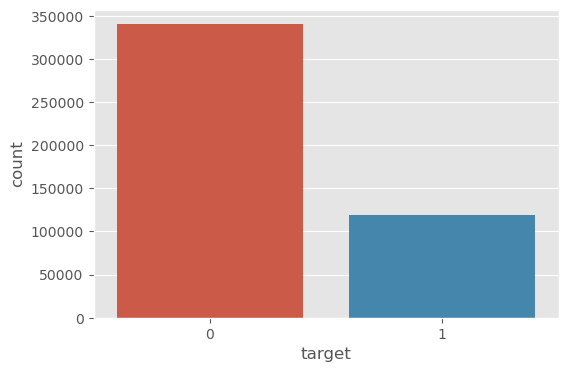

In [10]:
fig, ax = plt.subplots(figsize=(6,4))  
sns.countplot(x=train_labels.target)  
plt.show()  

In [12]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float16(177), int8(11), object(2)
memory usage: 2.0+ GB


In [13]:
#Convert S_2 to Time Format
train_dataframe['S_2'] = pd.to_datetime(train_dataframe['S_2'])  
test_dataframe['S_2'] = pd.to_datetime(test_dataframe['S_2'])  
  
train_dataframe['S_2'].min(), train_dataframe['S_2'].max()  

(Timestamp('2017-03-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))


#### NUMBER OF USERS VS MONTH OF SPEND

In [19]:
#### TO BE CHECKED 

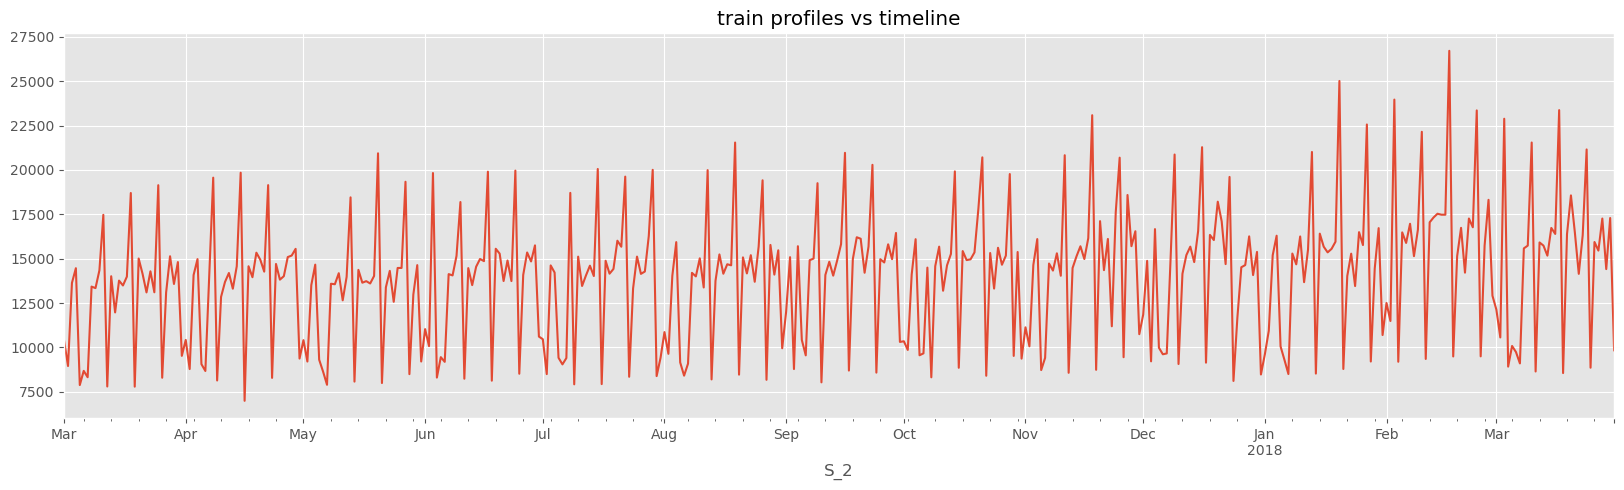

In [20]:

fig, ax = plt.subplots(figsize=(20,5))  
train_dataframe.groupby("S_2")['customer_ID'].count().plot()  
plt.title("train profiles vs timeline")  
plt.show()  

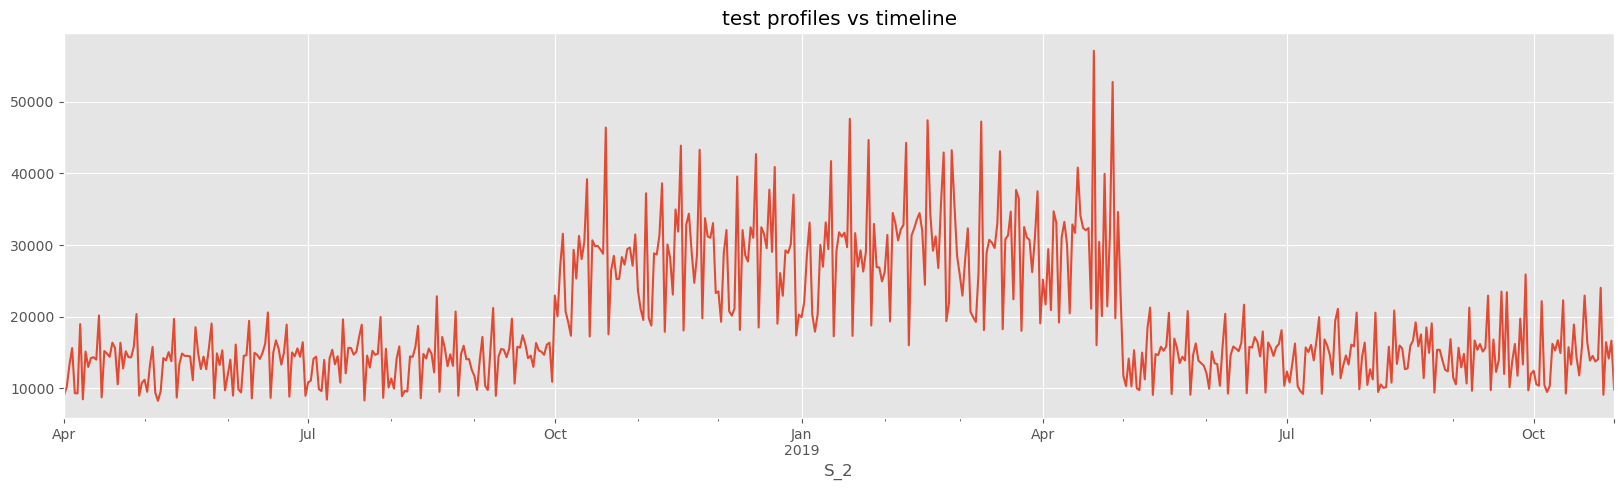

In [21]:
fig, ax = plt.subplots(figsize=(20,5))  
test_dataframe.groupby("S_2")['customer_ID'].count().plot()  
plt.title("test profiles vs timeline")  
plt.show()  

#FOR TRAIN --- THIS SHOWS THAT TRAIN DATA IS CONSISETENT AND TEST IS INCONSISTENT

### FEATURE SELECTION

In [25]:
#The code is effectively reducing both the training and test datasets to only the most recent data entries for each customer. This is a common preprocessing step when building models that predict outcomes based on the latest available data. The assumption is that the most recent features are the most relevant for predicting current or future customer behavior.


# Training data preparation  
# taking the latest profile features for each customer  
  
train_dataframe = train_dataframe.groupby("customer_ID").tail(1).reset_index(drop=True)  
test_dataframe = test_dataframe.groupby("customer_ID").tail(1).reset_index(drop=True)  
  
# Merge with targets  
train_dataframe = train_dataframe.merge(train_labels, on='customer_ID', how='left')  
  
target_col = 'target'  ## this is target column
drop_cols = ['customer_ID', 'S_2', target_col]  ## these are source columns on which we wamt the result and it will beexcluded from train dataset 
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']  ##these are main categorical vars
train_cols = [col for col in train_dataframe.columns if col not in drop_cols]  ##all cols except the drop cols
